2022.08.29   
DACON AI 양재허브 인공지능 오픈소스 경진대회   
Image Super-Resolution // PSNR

In [11]:
import pandas as pd
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import cv2
import os
from tqdm.auto import tqdm



Device 확인

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# CustomDataset

In [27]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, img_list, transform=None, train_mode=True):
        self.transform = transform
        self.train_mode = train_mode

        self.low_list = img_list['LR']
        if self.train_mode:
            self.high_list = img_list['HR']

    def __getitem__(self,index):
        low_path = './data/'+self.low_list.iloc[index][1:]
        low_img = cv2.imread(low_path)
        
        if self.transform is not None:
            low_img=self.transform(low_img)
        
        if self.train_mode:
            high_path = './data/'+self.high_list.iloc[index][1:]
            high_img = cv2.imread(high_path)
            return low_img, high_img
        else:
            return low_img
    
    def __len__(self):
        return len(self.low_list)


In [28]:
csv_path = os.getcwd()+'/data/train.csv'
df = pd.read_csv(csv_path)
print(df[:3])

                    LR                   HR
0  ./train/lr/0000.png  ./train/hr/0000.png
1  ./train/lr/0001.png  ./train/hr/0001.png
2  ./train/lr/0002.png  ./train/hr/0002.png


CustomDataset 확인하기

(512, 512, 3)


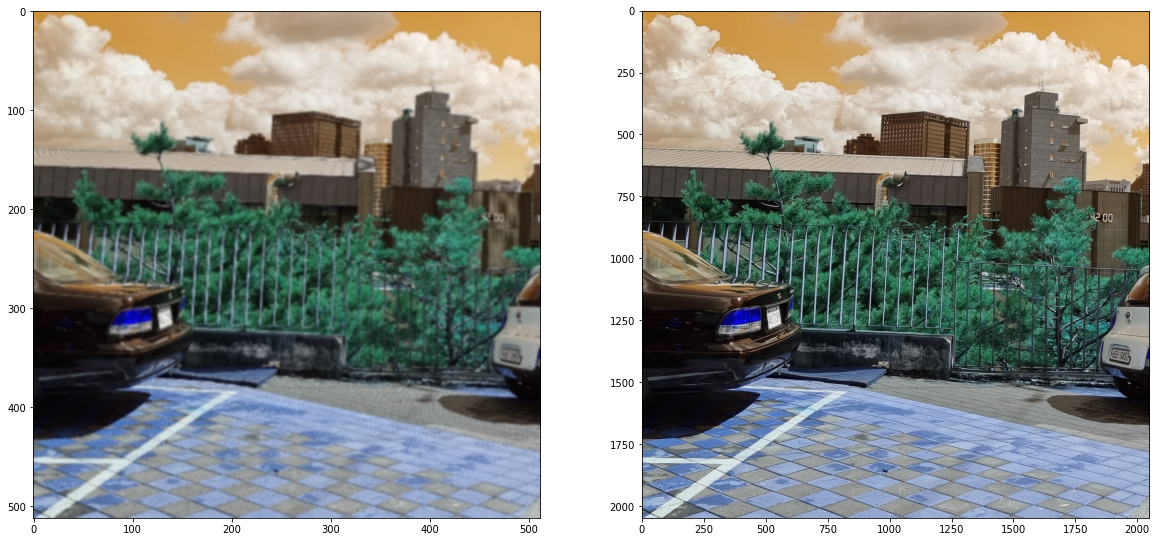

In [33]:
import matplotlib.pyplot as plt
temp_path = os.getcwd()+'/data/train.csv'
temp_list = pd.read_csv(temp_path)

temp_dataset = CustomDataset(temp_list,transform=None,train_mode=True)
low, high = temp_dataset.__getitem__(0)
print(low.shape)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(low)

plt.subplot(1,2,2)
plt.imshow(high)


In [10]:
BATCH_SIZE =16
IMG_SIZE=2048

# Transform

In [7]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize([512,512]),
    torchvision.transforms.ToTensor(),
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

In [34]:
train_path = os.getcwd()+'/data/train.csv'
train_list = pd.read_csv(train_path)

train_dataset = CustomDataset(train_list,train_transform,train_mode=True)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4)

test_path = os.getcwd()+'/data/test.csv'
test_list = pd.read_csv(test_path)
test_dataset = CustomDataset(test_list,test_transform,train_mode=False)
test_loader = DataLoader(test_dataset,BATCH_SIZE,False,num_workers=4)


KeyError: 'HR'

# Model

In [ ]:
class SRCNN(torch.nn.Module):
    def __init__(self, channels=3, feature_dim = 64, map_dim=32):
        super(SRCNN, self).__init__()
        self.features =torch.nn.Sequential(
            torch.nn.Conv2d(channels, feature_dim,kernel_size=3,padding='same',bias=True),
            torch.nn.ReLU(True)
        )

        self.map = torch.nn.Sequential(
            torch.nn.Conv2d(feature_dim,map_dim,kernel_size=5,padding='same',bias=True),
            torch.nn.ReLU(True)
        )
        self.reconstruction = torch.nn.Conv2d(map_dim,channels)
        self._initial_weights()

    def forward(self,x):
        features = self.features(x)
        maps = self.map(features)
        out = self.reconstruction(maps)
        return out
    def _intial_weight(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
                torch.nn.zeros_(m.bias.data)
            elif isinstance(m, (torch.nn.BatchNorm2d, torch.nn.GroupNorm)):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)
